# Lab 3b: finding flights in Landsat and Sentinel-2 imagery

<a target="_blank" href="https://colab.research.google.com/github/contrailcirrus/2024-06-contrails-workshop/blob/main/labs/landsat_sentinel/Landsat_Sentinel.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**Tristan Abbott (tristan.abbott@breakthroughenergy.org)**

This lab provides a tutorial on using [pycontrails](https://py.contrails.org/) to find commercial flights in high-resolution imagery from [Landsat](https://landsat.gsfc.nasa.gov/) and [Sentinel-2](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2) satellites. This provides a way to observe the earliest stages of the contrail lifecycle, before persistent contrails grow to a size that can be seen in geostationary imagery.

## Setup

We have to install pycontrails, and we include all optional dependencies except `jupyter`, which conflicts with Colab requirements.

In addition, we download a couple of files with [IAGOS](https://www.iagos.org/) flight data from a public cloud bucket.

In [ ]:
!pip install "pycontrails[ecmwf,gcp,gfs,pyproj,sat,vis,zarr]"

In [ ]:
!cd ~ && \
    wget https://storage.googleapis.com/2024-06-contrails-workshop/landsat_sentinel/iagos-flight-landsat.csv && \
    wget https://storage.googleapis.com/2024-06-contrails-workshop/landsat_sentinel/iagos-flight-sentinel.csv

## Background: Landsat and Sentinel-2 imagery

Landsat and Sentinel-2 provide imagery in a large number of wavelength bands. The image below highlights some useful bands for observing contrails:
- Bands B2/B02, B3/B03, and B4/B04 are visible bands that can be used to create true-color RGB composites.
- Bands B9 (Landsat) and B10 (Sentinel-2) are "cirrus bands" that are useful for detecting high clouds. Water vapor absorption in the lower atmosphere prevents reflection from objects on and near the surface, so radiances in cirrus bands are dominated by reflection from high clouds (and high-altitude aircraft).
- Landsat bands B10 and B11 are thermal infrared bands where top-of-atmosphere radiances are dominated by emission of terrestrial radiation. Band B10 is a "clean longwave window band" where greenhouse gases (water vapor, CO2, ozone) are weak absorbers. Low B10 radiances are typically the result of absorption by high clouds. Band B11 is a "dirty longwave window band" on the edge of the atmospheric window. Optical properties of cirrus differ between wavelengths imaged by bands B10 and B11, and the difference between B10 and B11 radiances can be used to distinguish between thin high clouds (which produce larger differences) and thick high clouds (which produce smaller differences).

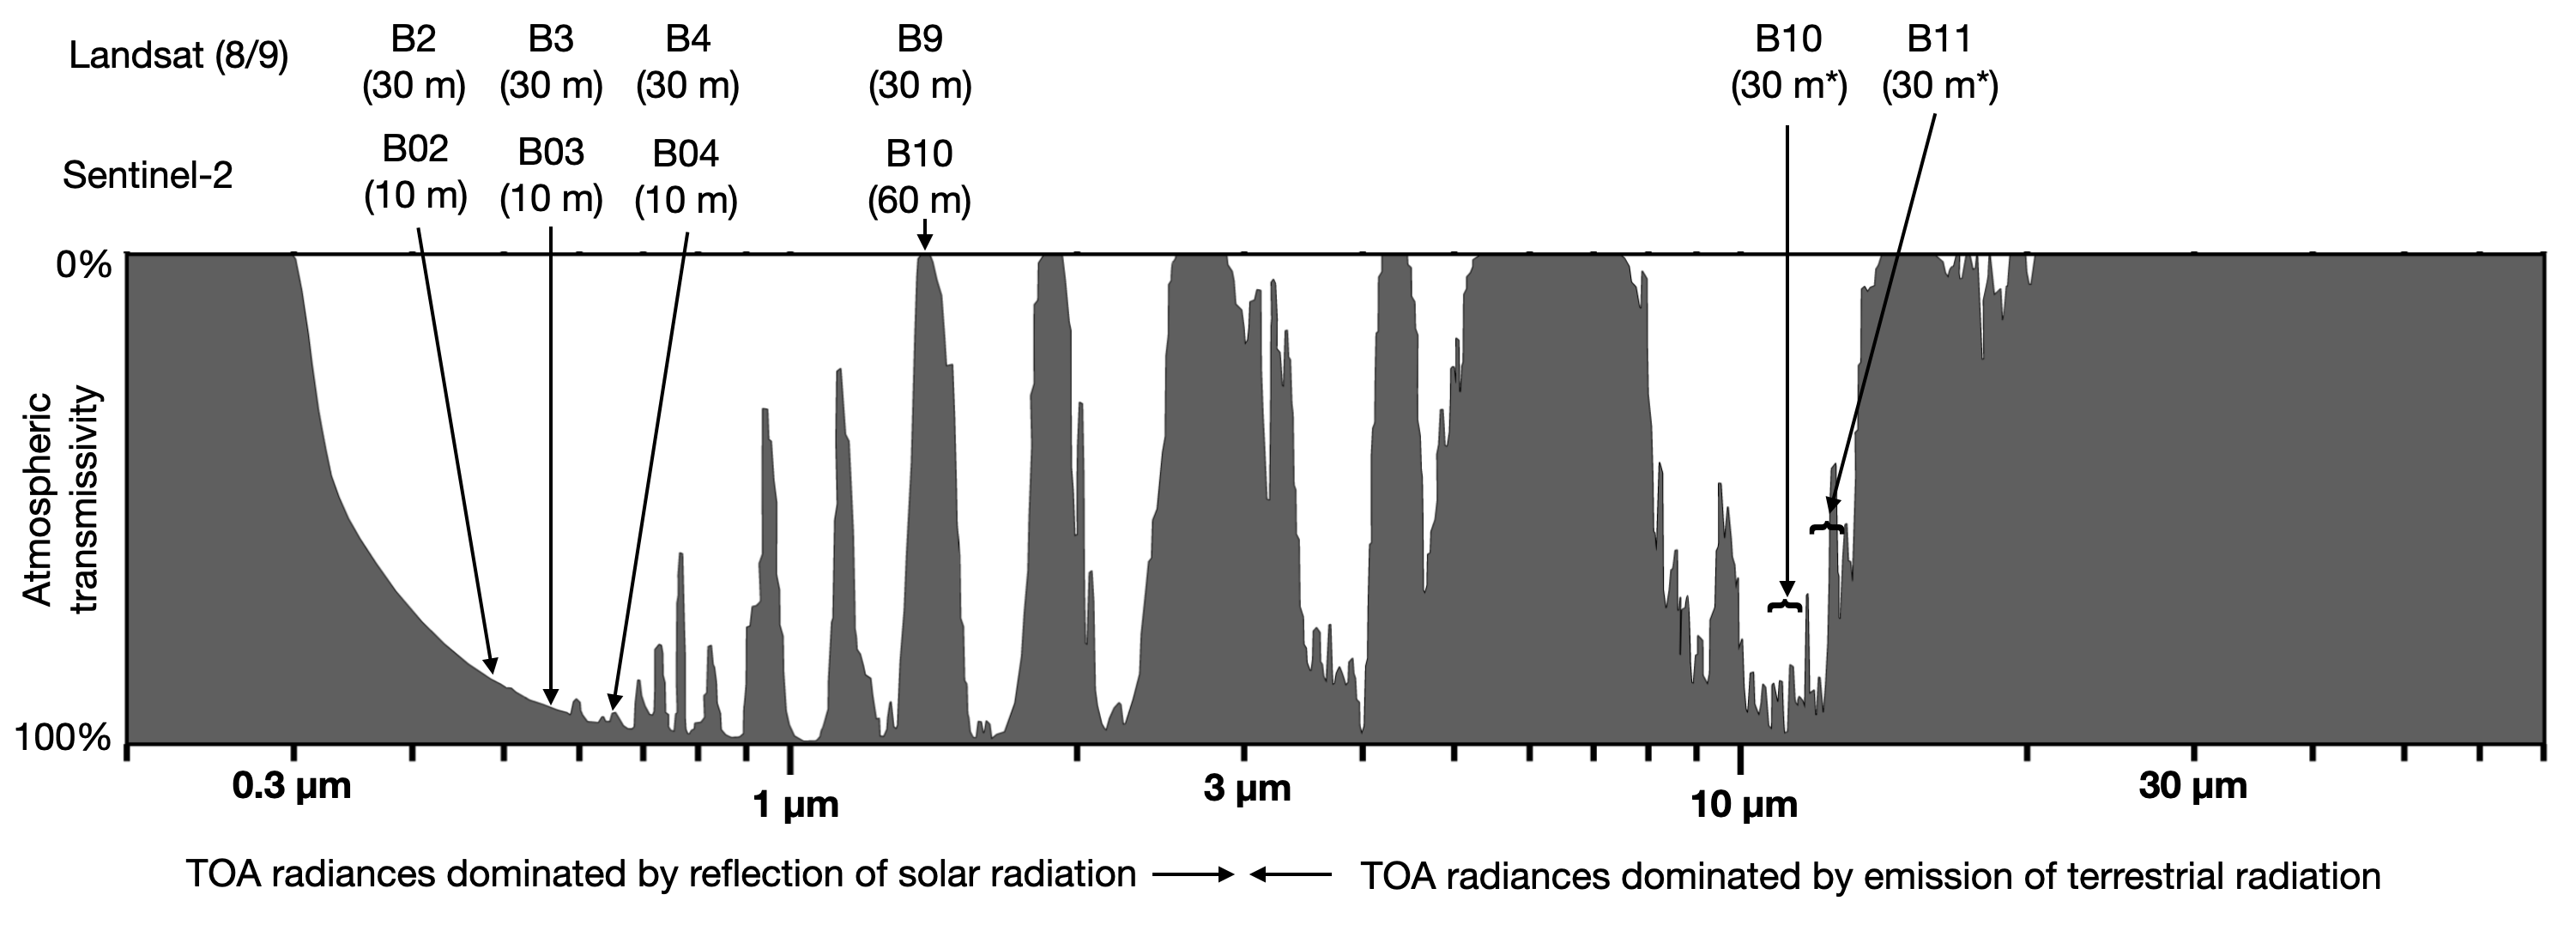

This lab uses Level-1C Landsat and Sentinel-2 imagery, which contains top-of-atmosphere radiances geolocated using [Universal Transverse Mercator](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) (UTM) coordinates. (Level-2A products provide atmospherically corrected surface reflectances, which is useful for things like vegetation analysis or land cover classification but not for looking at contrails!)

The UTM projection divides Earth into 60 longitudinal zones and projects each onto a plane using a [transverse Mercator projection](https://en.wikipedia.org/wiki/Transverse_Mercator_projection). Specifying a location in a satellite scene requires specifying the UTM zone and the x-y coordinates on the projection plane (referred to as "easting" and "northing").

## Part 1: intersecting flight tracks with satellite imagery

Pycontrails uses [BigQuery](https://cloud.google.com/bigquery) tables with [Landsat](https://cloud.google.com/storage/docs/public-datasets/landsat) and [Sentinel-2](https://cloud.google.com/storage/docs/public-datasets/sentinel-2) imagery metadata to find intersections between flight tracks and satellite scenes. This requires a Google Cloud Platform account with access to the BigQuery API.

Pycontrails defines an "intersection" as a satellite scene that contains flight waypoints both before and after the scene sensing time.

Part 2 of this lab (downloading and visualizing satellite imagery) does not require a GCP account and can be run independently from part 1.

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from pycontrails.core import Flight
from pycontrails.datalib import landsat, sentinel

In [ ]:
from google.colab import auth
auth.authenticate_user(project_id="...")

### Intersect Landsat scenes with IAGOS flight

An IAGOS flight track that intersects Landsat imagery is available in a public cloud bucket.

In [ ]:
df = pd.read_csv("~/iagos-flight-landsat.csv")
flight = Flight(data=df).resample_and_fill("1min")
scenes = landsat.intersect(flight, columns=["base_url", "sensing_time", "west_lon", "east_lon", "south_lat", "north_lat"])
scenes

In [ ]:
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([90, 130, 5, 30])
ax.plot(flight["longitude"], flight["latitude"], "b-", transform=ccrs.Geodetic())
for _, row in scenes.iterrows():
    x0 = row["west_lon"]
    y0 = row["south_lat"]
    w = row["east_lon"] - row["west_lon"]
    h = row["north_lat"] - row["south_lat"]
    plt.gca().add_patch(patches.Rectangle((x0, y0), w, h, ec="red", fc="none"))

### Intersect Sentinel-2 scenes with IAGOS flight

An IAGOS flight track that intersects Sentinel-2 imagery is also available in a public cloud bucket.

In [ ]:
df = pd.read_csv("~/iagos-flight-sentinel.csv")
flight = Flight(data=df).resample_and_fill("1min")
scenes = sentinel.intersect(flight, columns=["base_url", "sensing_time", "granule_id", "west_lon", "east_lon", "south_lat", "north_lat"])
scenes

In [ ]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection=ccrs.NearsidePerspective(central_longitude=-60, central_latitude=60))
ax.coastlines()
ax.set_global()
ax.plot(flight["longitude"], flight["latitude"], "b-", transform=ccrs.Geodetic())
for _, row in scenes.iterrows():
    x0 = row["west_lon"]
    y0 = row["south_lat"]
    w = row["east_lon"] - row["west_lon"]
    h = row["north_lat"] - row["south_lat"]
    plt.gca().add_patch(patches.Rectangle((x0, y0), w, h, ec="red", fc="none", transform=ccrs.Geodetic()))

## Part 2: downloading imagery and visualizing flights

Pycontrails downloads Landsat and Sentinel-2 imagery from public GCP buckets using anonymous access, which does not require a GCP account. Identifiers for downloaded imagery are taken from intersections from part 1 of the lab but hard-coded in this section for users without BigQuery access.

In [ ]:
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj

from pycontrails.core import Flight, GeoVectorDataset, JetA
from pycontrails.datalib import landsat, sentinel
from pycontrails.models import pcr as pcr_model
from pycontrails.physics import constants

### Visualize IAGOS flight in Landsat scene

In [ ]:
df = pd.read_csv("~/iagos-flight-landsat.csv")
df["time"] = df["time"].apply(lambda t: pd.Timestamp(t))

In [ ]:
base_url = "gs://gcp-public-data-landsat/LC08/01/124/048/LC08_L1TP_124048_20190112_20190131_01_T1"
sensing_time = pd.Timestamp("2019-01-12 03:05:55.144026+00:00")

In [ ]:
pcr, sac, issr = pcr_model.pcr(
    df["temperature"],
    df["h2o_gas_ppmv"]*1e-6*constants.R_d/constants.R_v,
    df["pressure"],
    0.3,
    JetA.ei_h2o,
    JetA.q_fuel
)

In [ ]:
plt.plot(df["time"], df["rhi"], "k-", ms = 1)
mask = issr == 1
plt.plot(df["time"], np.where(mask, df["rhi"], np.nan), "b-", label="ISSR")
mask = sac == 1
plt.plot(df["time"], np.where(mask, df["rhi"], np.nan), "r-", label="SAC")
mask = issr == 1
plt.plot(df["time"], np.where(mask, df["rhi"], np.nan), "g-", label="PCR")
plt.ylabel("RHi (nondim)")
plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%m/%d\n%H:%M"))
plt.gca().axhline(y=1, color="gray", ls="--")
plt.gca().axvline(x=sensing_time, color="gray", ls="--");
plt.legend(loc="upper right", frameon=False)

#### Download imagery

We download bands 2, 3, 4 (visible wavelengths), band 9 (reflective cirrus band), and bands 10 and 11 (emissive longwave bands).

In [ ]:
handler = landsat.Landsat(base_url, bands=["B2", "B3", "B4", "B9", "B10", "B11"])
ds = handler.get()
ds

#### True-color image

Bands 2, 3, and 4 can be used to create a true-color image.

In [ ]:
rgb, crs, extent = landsat.extract_landsat_visualization(ds, color_scheme="true")

Here is the image--but where is the plane?

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")

The `crs` artifact returned by `extract_landsat_visualization` can be used to project flight coordinates (latitude and longitude) into image coordinates (easting and northing).

In [ ]:
# interpolate flight location to satellite sensing time
flight_lon = np.interp(
    sensing_time.timestamp(),
    df["time"].apply(lambda t: t.timestamp()),
    df["longitude"],
)
flight_lat = np.interp(
    sensing_time.timestamp(),
    df["time"].apply(lambda t: t.timestamp()),
    df["latitude"],
)

# convert coordinates
proj = pyproj.Transformer.from_crs(crs.geodetic_crs, crs)
flight_x, flight_y = proj.transform(flight_lat, flight_lon)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.plot(flight_x, flight_y, "ro")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.plot(flight_x, flight_y, "ro")
plt.xlim([flight_x - 10e3, flight_x + 10e3])
plt.ylim([flight_y - 10e3, flight_y + 10e3])
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")

There is a slight error between the projected flight coordinates and the position of the flight in the image because the scene is imaged at an angle and geolocated at the surface. There are even smaller offsets between different wavelengths because different bands are imaged at slightly different angles and aligned at the surface.

#### Cirrus band

Contrails and aircraft both appear as regions of high reflectance in the cirrus band.

In [ ]:
crs = ds["B9"].attrs["crs"]
proj = pyproj.Transformer.from_crs(crs.geodetic_crs, crs)
flight_x, flight_y = proj.transform(flight_lat, flight_lon)

In [ ]:
plt.figure(figsize=(12, 10))
ds["B9"].sel(
    x=slice(flight_x - 10e3, flight_x + 10e3),
    y=slice(flight_y + 10e3, flight_y - 10e3)
).plot(cmap="Greys_r")
plt.gca().set_aspect("equal", "box")
plt.plot(flight_x, flight_y, "w.")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")

#### False-color longwave image

This color scheme was designed by researchers at Google for [contrail detection in Landsat imagery](https://research.google/pubs/a-human-labeled-landsat-contrails-dataset/) and combines band 9 (reflective cirrus band) with bands 10 and 11 (emissive longwave bands). This color scheme is good for visualizing aged contrails, but high-altitude misalignment between bands make it more difficult to use for aircraft and very young contrails

In [ ]:
rgb, crs, extent = landsat.extract_landsat_visualization(ds, color_scheme="google_contrails")

In [ ]:
proj = pyproj.Transformer.from_crs(crs.geodetic_crs, crs)
flight_x, flight_y = proj.transform(flight_lat, flight_lon)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(rgb, extent=extent)
plt.plot(flight_x, flight_y, "ko")
plt.xlim([flight_x - 20e3, flight_x + 20e3])
plt.ylim([flight_y - 20e3, flight_y + 20e3])
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")

### Visualize IAGOS flight in Sentinel-2 scene

In [ ]:
df = pd.read_csv("~/iagos-flight-sentinel.csv")
df["time"] = df["time"].apply(lambda t: pd.Timestamp(t))

In [ ]:
base_url = "gs://gcp-public-data-sentinel-2/tiles/11/U/LS/S2A_MSIL1C_20191209T190801_N0208_R013_T11ULS_20191209T204542.SAFE"
sensing_time = pd.Timestamp("2019-12-09 19:10:16.859000+00:00")
granule_id = "L1C_T11ULS_A023319_20191209T190758"

In [ ]:
pcr, sac, issr = pcr_model.pcr(
    df["temperature"],
    df["h2o_gas_ppmv"]*1e-6*constants.R_d/constants.R_v,
    df["pressure"],
    0.3,
    JetA.ei_h2o,
    JetA.q_fuel
)

In [ ]:
plt.plot(df["time"], df["rhi"], "k-", ms = 1)
mask = issr == 1
plt.plot(df["time"], np.where(mask, df["rhi"], np.nan), "b-", label="ISSR")
mask = sac == 1
plt.plot(df["time"], np.where(mask, df["rhi"], np.nan), "r-", label="SAC")
mask = issr == 1
plt.plot(df["time"], np.where(mask, df["rhi"], np.nan), "g-", label="PCR")
plt.ylabel("RHi (nondim)")
plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%m/%d\n%H:%M"))
plt.gca().axhline(y=1, color="gray", ls="--")
plt.gca().axvline(x=sensing_time, color="gray", ls="--");
plt.legend(loc="upper center", frameon=False)

#### Download imagery

We download band 10 (reflective cirrus band). 

The Sentinel-2 satellite provides visible bands that can be used to create a true-color composite, but the very high resolution (10 m/pixel) of these bands makes them slow to download and process, so we will skip them during the lab.

In [ ]:
handler = sentinel.Sentinel(base_url, granule_id, bands=["B10"])
ds = handler.get()
ds

In [ ]:
flight_lon = np.interp(
    sensing_time.timestamp(),
    df["time"].apply(lambda t: t.timestamp()),
    df["longitude"],
)
flight_lat = np.interp(
    sensing_time.timestamp(),
    df["time"].apply(lambda t: t.timestamp()),
    df["latitude"],
)

In [ ]:
crs = ds["B10"].attrs["crs"]
proj = pyproj.Transformer.from_crs(crs.geodetic_crs, crs)
flight_x, flight_y = proj.transform(flight_lat, flight_lon)

In [ ]:
plt.figure(figsize=(12, 10))
ds["B10"].plot(cmap="Greys_r")
plt.gca().set_aspect("equal", "box")
plt.plot(flight_x, flight_y, "w.")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")

In [ ]:
plt.figure(figsize=(12, 10))
ds["B10"].sel(
    x=slice(flight_x - 10e3, flight_x + 10e3),
    y=slice(flight_y + 10e3, flight_y - 10e3)
).plot(cmap="Greys_r")
plt.gca().set_aspect("equal", "box")
plt.plot(flight_x, flight_y, "w.")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")

## Concluding remarks

- Landsat and Sentinel-2 scenes provide metadata that can be used to reconstruct viewing angles within a scene. This provides a way (with some engineering effort) to more accurately geolocate aircraft within a satellite scheme.

- Offsets between different bands might provide a way to estimate the altitude of features in satellite images, though it's unclear if the combination of pixel size and viewing angle would provide a useful level of precision.

- Landsat and Sentinel-2 data provide a way to unambiguously attribute *very* young contrails to flights. One outstanding question: how long does it take for the mapping from contrails to flights to become less obvious? (Does the mapping become non-obvious long before contrails become visible in geostationary imagery?)

- We are happy to collaborate if you're interested in using these tools, but collaboration is not required to use them! (They're hopefully-useful but fairly simple wrappers around public datasets.) 